In [26]:
import numpy as np
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

## Read df and preprocess

In [3]:
df = pd.read_csv('short.csv')
df.head()

,text,tag
0,How can you see into my eyes like open doors ?...,metal
1,I'm so tired of being here Suppressed by all m...,metal
2,Another head hangs lowly Child is slowly taken...,metal
3,Before the story begins Is it such a sin For m...,metal
4,Remember when Hell had frozen over ? The cold ...,metal


In [5]:
df.shape

(25000, 2)

In [6]:
df = df[['text', 'tag']]
df.columns = ['lyrics', 'genre']
df.head()

,lyrics,genre
0,How can you see into my eyes like open doors ?...,metal
1,I'm so tired of being here Suppressed by all m...,metal
2,Another head hangs lowly Child is slowly taken...,metal
3,Before the story begins Is it such a sin For m...,metal
4,Remember when Hell had frozen over ? The cold ...,metal


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# Remove stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [stemmer.stem(word) for word in text if word not in stop_words and word not in string.punctuation and len(word)]
    return ' '.join(text)

train_df['lyrics'] = train_df['lyrics'].apply(preprocess_text)
test_df['lyrics'] = test_df['lyrics'].apply(preprocess_text)

In [10]:
# Apply tf idf on feature (lyrics)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=0.0001)
X_train = tfidf.fit_transform(train_df['lyrics'])
X_test = tfidf.transform(test_df['lyrics'])
X_train.shape

(20000, 45590)

In [11]:
# # n-grams bag of words
# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(ngram_range=(1, 2))
# X_train = cv.fit_transform(train_df['lyrics'])
# X_test = cv.transform(test_df['lyrics'])
# X_train.shape

In [12]:
# Encode target
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
y_train = encoder.fit_transform(train_df[['genre']]).ravel()
y_test = encoder.transform(test_df[['genre']]).ravel()
y_train.shape

(20000,)

## Classical ML models

In [64]:
# classification report

def create_report(y_test, y_pred, name):
    cr = pd.DataFrame(classification_report(y_test, y_pred, target_names=encoder.categories_[0], output_dict=True)).T
    cr = cr.loc[['metal', 'pop', 'rap', 'rb', 'rock']]
    # only f1 score
    cr = pd.DataFrame(cr.loc[:, 'f1-score'])
    # rename column f1-score to logreg
    cr = cr.rename(columns={'f1-score': f'{name}'})
    # transpose
    cr = cr.T
    # rename row
    return cr

In [65]:
metrics = pd.DataFrame()

In [66]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = SGDClassifier(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted')

metrics = pd.concat([metrics, create_report(y_test, y_pred, 'SGD')])

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted')

metrics = pd.concat([metrics, create_report(y_test, y_pred, 'LogReg')])

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted')

metrics = pd.concat([metrics, create_report(y_test, y_pred, 'DecTree')])

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted')

metrics = pd.concat([metrics, create_report(y_test, y_pred, 'KNN')])

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted')

metrics = pd.concat([metrics, create_report(y_test, y_pred, 'RandFor')])

In [73]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted')

metrics = pd.concat([metrics, create_report(y_test, y_pred, 'GradBoost')])

In [74]:
metrics

,metal,pop,rap,rb,rock
SGD,0.784021,0.488360,0.766776,0.575294,0.570450
LogReg,0.799814,0.509498,0.779609,0.608840,0.575906
DecTree,0.596071,0.363905,0.661818,0.477215,0.390633
KNN,0.321908,0.347975,0.349544,0.428476,0.119454
RandFor,0.759316,0.503213,0.794481,0.560453,0.525424
GradBoost,0.755412,0.497024,0.795144,0.598532,0.546247


In [75]:
metrics.to_csv('eda/metrics.csv')

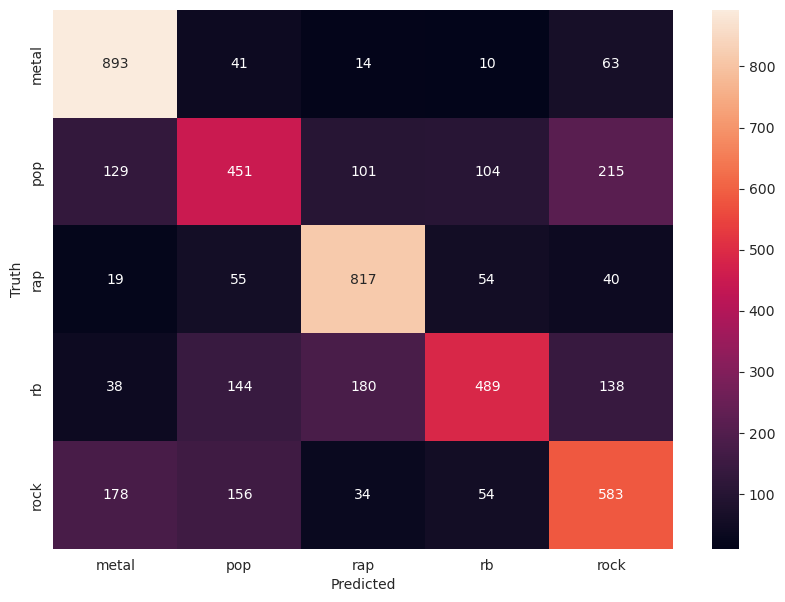

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
